In [1]:
import matplotlib.pyplot as plt
import numpy as np
from math import sqrt,prod

import torch

import demeter.utils.torchbox as tb
import demeter.utils.vector_field_to_flow as vff
from demeter.constants import *
from demeter.utils.decorators import monitor_gpu
from draft.draft_affine_3D import torch_affine_registration
%load_ext autoreload
%autoreload 2
import demeter.utils.reproducing_kernels as rk
import demeter.metamorphosis as mt


def tp(x):
    """ prepare simplex tensor to be plotted as an image

    """
    tp_img = x[0].permute(1,2,0).cpu().numpy()
    if tp_img.shape[-1] in [3,4]:
        return tp_img
    elif tp_img.shape[-1] == 2:
        z_shape = tp_img.shape[:-1]
        zero = np.zeros(z_shape + (1,))
        return np.concatenate(
            [tp_img,zero],axis=-1
        )

def to_plot(img):
    if img.shape[-1] == 3:
        return img
    elif img.shape[-1] == 4:
        return img[...,:-1]

def make_exp(xxx, yyy, centre, sigma):
    ce_x, ce_y = centre
    sigma_x,sigma_y = sigma
    exp = torch.exp(
        - 0.5*((xxx - ce_x) / sigma_x) ** 2
        - 0.5*((yyy - ce_y) / sigma_y) ** 2)
    return exp


## Residual métric

def get_deformator(mp,from_t=0,to_t=None,save=False):
    temporal_integrator = vff.FieldIntegrator(method='temporal',save=save)
    if from_t is None and to_t is None:
        print('Je suis passé par là')
        return temporal_integrator(mp.field_stock/mp.n_step, forward=False)
    # if from_t is None: from_t = 0
    if to_t is None: to_t = mp.n_step
    if from_t < 0 and from_t >= to_t:
        raise ValueError(f"from_t must in [0,n_step-1], got from_t ={from_t} and n_step = {mp.n_step}")
    if to_t > mp.n_step:
        raise ValueError(f"to_t must in [from_t+1,n_step], got to_t ={to_t} and n_step = {mp.n_step}")
    if to_t==1:
        return mp.id_grid.detach().cpu() - mp.field_stock[0][None].detach().cpu() / mp.n_step
    # ic(from_t,to_t,mp.field_stock[from_t:to_t].shape)
    return temporal_integrator(mp.field_stock[from_t:to_t]/mp.n_step, forward=False)

# Plot visu registration:
def get_resi_cumul_onTarget(mr, debug = False ) :
    resi_sum = torch.zeros_like(mr.target)
    N = mr.mp.residuals_stock.shape[0]
    if debug:
        fig,ax = plt.subplots(2,N,figsize=(5*N,10),constrained_layout=True)

    for i in range(N):
        deform_t = get_deformator(mr.mp,from_t=i,save=False)
        # ic(mr.mp.residuals_stock[i].min(),mr.mp.residuals_stock[i].max())
        resi_sum += sqrt(1 - mr._get_rho_()) * tb.imgDeform(mr.mp.residuals_stock[i][None], deform_t,dx_convention=mr.dx_convention) / mr.mp.n_step
        # ic(resi_sum.min(),resi_sum.max())
        if debug:
            to_show_r = resi_sum.squeeze().permute(1,2,0).numpy()
            ax[0,i].imshow(to_show_r[...,:-1])
            ax[1,i].imshow(mr.mp.residuals_stock[i].squeeze().permute(1,2,0).numpy()[...,:-1])
            set_ticks_off(ax)
    return resi_sum

def residual_quality_metric(mr,resi_rhoInfty):
    resi_sum = get_resi_cumul_onTarget(mr,debug=False)
    return torch.sum((resi_sum - resi_rhoInfty ) ** 2)

def plot_endresult(mr,save=False, return_all=False,filename=None):
    image_ts = tp(mr.mp.image) **2
    # momentum_ts = mr.mp.momentum.permute(0,2,3,1).squeeze().cpu().detach().numpy()
    momentum_ts = tp(mr.mp.momentum)

    # ic(image_ts.shape)
    residual_cumul = get_resi_cumul_onTarget(mr,debug=False)#.cpu().permute(0,2,3,1)[0]
    # print('residual_cumul.shape:',residual_cumul.shape)
    # residual_cumul = residual_cumul.sum(dim=-1)
    # residual_cumul = residual_cumul
    #residual_ts = mr.mp.residuals.squeeze().permute(1,2,0).numpy()

    deform = mr.mp.get_deformation()
    # print("source dtype",source.dtype)
    # print("deformator",mr.mp.get_deformator().dtype)
    im_deformed_only = tb.imgDeform(source.to('cpu'),mr.mp.get_deformator().cpu(),dx_convention=mr.dx_convention)
    im_deformed_only = tp(im_deformed_only)

    diff_im_t = np.sum(np.abs(image_ts-tp(target)),axis=-1)
    diff_im_def = np.sum(np.abs(im_deformed_only-tp(target)),axis=-1)

    metric_ssd = np.sqrt(np.sum((image_ts-tp(target))**2))
    metric_sdd_def_only = np.sqrt(np.sum((im_deformed_only-tp(target))**2))

    fig,ax = plt.subplots(3,3,figsize=(10,10),constrained_layout=True)
    fig.suptitle(mr.mp, fontsize=16)
    ax[0,0].imshow(tp(source))
    ax[0,0].set_title("Source")
    ax[0,1].imshow(tp(target))
    ax[0,1].set_title("Target")

    step = max(1,deform.shape[1]//15)
    tb.gridDef_plot_2d(deform,step=step,ax=ax[0,2],check_diffeo=True,origin = 'lower')


    ax[1,1].imshow(image_ts)
    ax[1,1].set_title("Image")
    ax[1,0].imshow(momentum_ts)
    ax[1,0].set_title("Momentum")
    # ic(residual_cumul.shape)
    # ic(residual_cumul.dtype)
    d = ax[1,2].imshow(tp(residual_cumul))
    fig.colorbar(d, ax=ax[1,2])
    ax[1,2].set_title("Cumulative residual")

    ax[2,0].imshow(im_deformed_only)
    ax[2,0].set_title(f"only Deformed Source")
    d = ax[2,1].imshow(diff_im_t,cmap="RdYlGn_r")
    fig.colorbar(d, ax=ax[2,1])
    ax[2,1].set_title(f"Diff Image Target = {metric_ssd:.2f}")
    d = ax[2,2].imshow(diff_im_def,cmap="RdYlGn_r")
    fig.colorbar(d, ax=ax[2,2])
    ax[2,2].set_title(f"Diff Image only deformed m = {metric_sdd_def_only:.2f}")


    set_ticks_off(ax)
    if save:
        if filename is None:
            filename = f"{path_save}{name}_{mr.mp.kernelOperator.sigma_continuous.tolist()}_summary.png"
        else:
            filename = f"{path_save}{filename}.png"
        plt.savefig(filename)

    if return_all:
        return {"metric_ssd" : metric_ssd,
                "metric_sdd_def_only" : metric_sdd_def_only,
                "im_deformed_only" : im_deformed_only,
                "image_ts" : image_ts,
                "momentum_ts" : momentum_ts,
                "residual_cumul" : residual_cumul
                }
    else:
        return metric_ssd,metric_sdd_def_only

# =========================================================
#
# EXPERIENCES
#
# =========================================================


def experience_1(size,sigma):
    H,W = size

    id_grid = tb.make_regular_grid((H,W),dx_convention = 'square')
    xx,yy = id_grid[0,...,0], id_grid[0,...,1]

    ## Background simplex
    image = torch.zeros((1,2,H,W))
    image[0,0] = xx >= .5
    image[0,1] = (xx <.5)

    moving = image.clone()

    # add exps
    sigma_exp1 = (0.3*sigma,0.3*sigma)
    sigma_exp2 = (sigma,sigma)
    exp = make_exp(xx,yy,(.5,.8),sigma_exp1)
    exp += make_exp(xx,yy,(.5,.3),sigma_exp2)

    image[0,1] = (xx-0.2*exp)<0.5
    image[0,0] =1 - image[0,1]
    fixed = image.clone()
    name = 'add_vol_sigma'
    return moving,fixed, name

def experience_2(size,sigma):
    H,W = size

    id_grid = tb.make_regular_grid((H,W),dx_convention = 'square')
    xx,yy = id_grid[0,...,0], id_grid[0,...,1]

    ## Background simplex
    image = torch.zeros((1,2,H,W))
    # image[0,0] = xx >= .5
    # image[0,1] = (xx <.5)
    centre = (0.5,0.5)
    boule = (xx - centre[0])**2 + (yy - centre[1])**2 < 0.2**2
    image[0,0] = boule
    image[0,1] = torch.logical_not(boule)

    moving = image.clone()

    # add exps
    sigma_exp1 = (sigma,sigma)    # centre = (0.5,0.5)
    # boule = (xx - centre[0])**2 + (yy - centre[1])**2 < 0.2**2
    # image[0,0] = boule
    # image[0,1] = torch.logical_not(boule)

    sigma_exp2 = (sigma,sigma)
    exp = make_exp(xx,yy,(.6,.5),sigma_exp1) * .2
    # exp += make_exp(xx,yy,(.5,.3),sigma_exp2)
    # new_grid = id_grid.clone()
    # new_grid[0,...,0] = xx - exp
    # new_grid[0,...,1] = yy + .5*exp
    # tb.gridDef_plot(new_grid,step=10)
    #
    newboule = (xx + exp - centre[0])**2 + (yy -exp - centre[1])**2 < 0.2**2
    # plt.figure()
    # plt.imshow(boule.to(int) - newboule.to(int))
    # plt.show()
    image[0,0] = newboule
    # image[0,0] =1 - image[0,1]
    image[0,1] = torch.logical_not(newboule)
    fixed = image.clone()
    name = 'cst_border'
    return moving,fixed, name




def experience_3(size,sigma):
    H,W = size

    id_grid = tb.make_regular_grid((H,W),dx_convention = 'square')
    xx,yy = id_grid[0,...,0], id_grid[0,...,1]


    ## Background simplex
    image = torch.zeros((1,2,H,W))
    image[0,0] = (xx >= .5)
    image[0,1] = (xx <.5)
    #image[0,0] = th(xx - .5)
    #image[0,1] = th(.5-  xx)
    print(image.max())

    moving = image.clone()

    # add exps
    sigma_exp1 = (0.3*sigma,0.3*sigma)
    sigma_exp2 = (2*sigma,sigma)
    exp = make_exp(xx,yy,(.5,.3),sigma_exp2)
    exp += make_exp(xx,yy,(.5,.7),sigma_exp1)

    image[0,1] = (xx-0.3*(1-yy)*(40*yy**2).sin())<.5
    image[0,0] =1 - image[0,1]
    fixed = image.clone()
    name = 'sin_scale'
    return moving,fixed, name

def experience_4(size):
    H,W = size

    id_grid = tb.make_regular_grid((H,W),dx_convention = 'square')
    xx,yy = id_grid[0,...,0], id_grid[0,...,1]


    ## Background simplex
    image = torch.zeros((1,2,H,W))
    image[0,0] = (xx >= .42)
    image[0,1] = (xx <.42)
    #image[0,0] = th(xx - .5)
    #image[0,1] = th(.5-  xx)
    print(image.max())

    moving = image.clone()
    
    ref = tb.reg_open("25", size=size)
    fixed = torch.zeros_like(moving)
    fixed[0,0] = 1 - ref[0,0]
    fixed[0,1] = ref[0,0]
    
    name = 'wave'
    return moving,fixed, name



saves_overview.csv


tensor(1.)


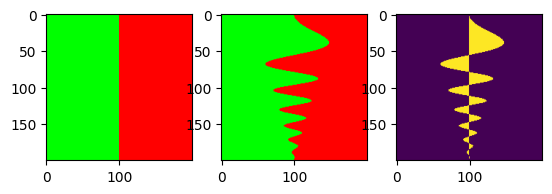

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
size = (300,300)
# source,target, name = experience_1(size,.1)
# source,target, name = experience_2((200,400),.08)
source,target, name = experience_3((200,200),.08)
# source,target, name = experience_4(size)

path_save = ROOT_DIRECTORY + f"/examples/results/simplex_result/{name}/"
if not os.path.exists(path_save):
    os.makedirs(path_save)


fig,ax = plt.subplots(1,3)
ax[0].imshow(tp(source))
ax[1].imshow(tp(target))
diff = torch.sum(torch.abs(source-target),dim=1)
ax[2].imshow(diff[0])
plt.show()

### Make kernels

#### New VolNormalizedGaussianRKHS version

(0.005025125628140704, 0.005025125628140704)
VolNormalizedGaussianRKHS,2D 
	filter :fft_filter, 
	sigma_pixel :tensor([13.9300, 13.9300])
	sigma_continous :tensor([0.0700, 0.0700])
	kernel_size :(1, 279, 279)


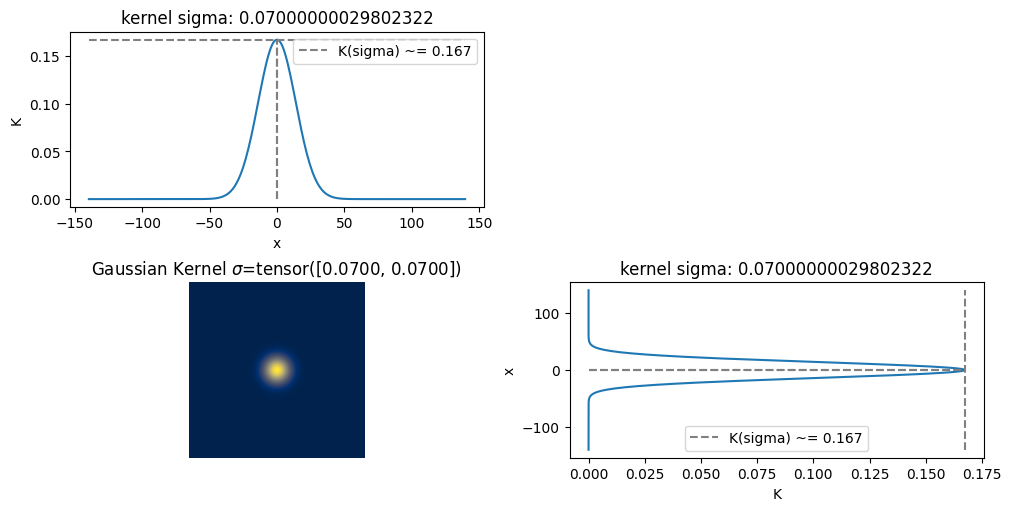

In [7]:
data_cost = mt.Ssd_normalized(target)
dx = tuple([1./(s-1) for s in source.shape[2:]])
# dx = (1,1)
print(dx)
s=0.07
sigma = (s,s)
# sigma = (3,9)
kernelOperator = rk.VolNormalizedGaussianRKHS(
        sigma=sigma,
        sigma_convention='continuous', # by passing 'continuous' we specify that sigma is continuous and compute sigma_pixel using dx
        dx=dx,
        border_type='constant',
    kernel_reach=10
    )

print(kernelOperator)
data_cost = mt.Ssd_normalized(target.to(device))
kernelOperator.plot()
plt.show()


### AS-ANG Kernel

(0.005025125628140704, 0.005025125628140704)
(2,)
0 0
All_Scale_Anisotropic_Normalized_Gaussian_RKHS+            (
	sigma=tensor([21, 21]),
	sigma_continuous=tensor([0.1055, 0.1055]),
	 k=4,
	 dx=(0.005025125628140704, 0.005025125628140704),
	 kernel_size=torch.Size([1, 105, 105])
)
kernel min max 5.06591845805815e-07 0.011337868869304657
torch.Size([105, 105])


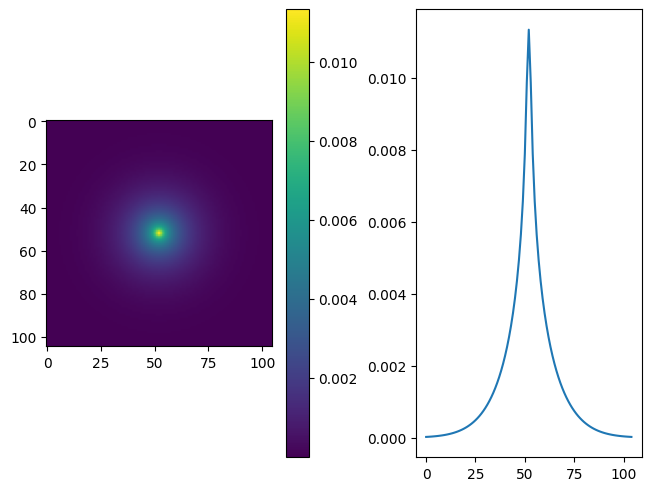

In [6]:
data_cost = mt.Ssd_normalized(target)
dx = tuple([1./(s-1) for s in source.shape[2:]])
# dx = (1,1)
print(dx)
# s=0.03
# sigma = (s,s)
s = 21
sigma = (s,s)
kernelOperator = rk.All_Scale_Anisotropic_Normalized_Gaussian_RKHS(
        sigma=sigma,
        sigma_convention='pixel', # by passing 'continuous' we specify that sigma is continuous and compute sigma_pixel using dx
        k = 4,
        dx=dx,
        # kernel_size = [150,150]
    )
print(kernelOperator)

# image = kernelOperator(source.cpu())
# print("image min max",image.min(), image.max())

print("kernel min max",kernelOperator.kernel.min().item(), kernelOperator.kernel.max().item())
# print("diff min max :",kernelOperator.kernel.max().item() - kernelOperator.kernel.min().item())

kernel  = kernelOperator.kernel[0].cpu()
print(kernel.shape)
h,w  = kernel.shape
fig,ax = plt.subplots(1,2, constrained_layout=True)
a = ax[0].imshow(kernel)
fig.colorbar(a, ax=ax[0])
ax[1].plot(kernel[h//2])
plt.show()


## Metamorphosis parameters

In [8]:
rho = 1
dx_convention = 'pixel'
integration_steps=20
n_iter=20
grad_coef=2
cost_cst=.1
lbfgs_history = 50

print(data_cost)

DataCost  :(Ssd_normalized)


## Shooting Metamorphosis

Progress: [----------]   4.00%  (Ssd_normalized : ,  0.0801).
Progress: [#---------]   6.00%  (Ssd_normalized : ,  0.0639).
Progress: [#---------]   8.00%  (Ssd_normalized : ,  0.0483).
Progress: [#---------]  10.00%  (Ssd_normalized : ,  0.0432).
Progress: [#---------]  12.00%  (Ssd_normalized : ,  0.0357).
Progress: [#---------]  14.00%  (Ssd_normalized : ,  0.0343).
Progress: [##--------]  16.00%  (Ssd_normalized : ,  0.0329).
Progress: [##--------]  18.00%  (Ssd_normalized : ,  0.0322).
Progress: [##--------]  20.00%  (Ssd_normalized : ,  0.0314).
Progress: [##--------]  22.00%  (Ssd_normalized : ,  0.0309).
Progress: [##--------]  24.00%  (Ssd_normalized : ,  0.0301).
Progress: [###-------]  26.00%  (Ssd_normalized : ,  0.0295).
Progress: [###-------]  28.00%  (Ssd_normalized : ,  0.0287).
Progress: [###-------]  30.00%  (Ssd_normalized : ,  0.0272).
Progress: [###-------]  32.00%  (Ssd_normalized : ,  0.0267).
Progress: [###-------]  34.00%  (Ssd_normalized : ,  0.0263).
Progress

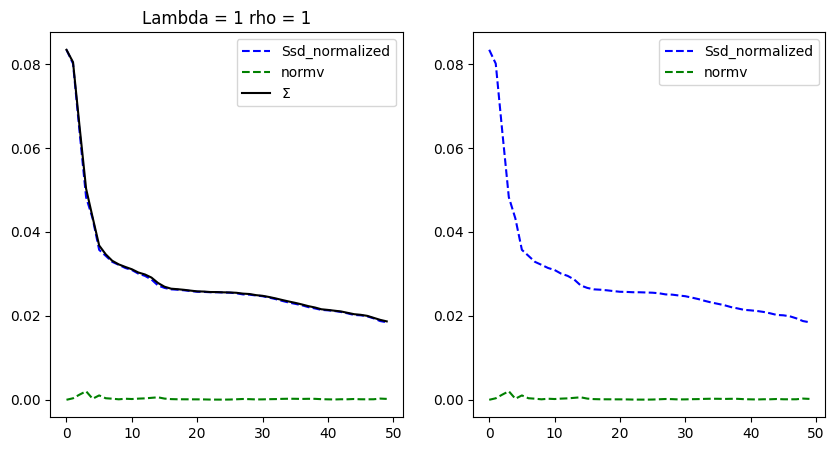

In [9]:
# "Normal" simplex metamorphosis
# =============================================
cost_cst=1  # On a besoin de beaucoup régulariser
n_iter=50
# rho = .95   # pour tester avec metamorphoses par curiosité.

# grad_coef=1 # Pour K AS-ANG

source = source.to(device).contiguous()#.to(torch.double)
target = target.to(device).contiguous()#.to(torch.double)
# 
@monitor_gpu
def shooting_meta():
    momentum_ini = torch.zeros_like(source)
    # momentum_ini = mr_shooting.to_analyse[0].to('cuda')
    momentum_ini.requires_grad = True
    ic.disable()
    mr_shooting = mt.simplex_metamorphosis(source.clone(),target.clone(),momentum_ini,kernelOperator,rho,
            integration_steps= integration_steps,
           n_iter=n_iter,
           grad_coef=grad_coef,
           cost_cst=cost_cst,
           data_term =data_cost ,
           dx_convention=dx_convention,
        ham = True,
        lbfgs_history_size=lbfgs_history,    
        )
    return mr_shooting

mr_shooting = shooting_meta()
fig_cost,_ =mr_shooting.plot_cost()
plt.show()

/home/turtlefox/Documents/11_metamorphoses/Demeter_metamorphosis/src/demeter/metamorphosis/abstract.py:593: RuntimeWarning: Failed to access the underlying source code for analysis. Was ic() invoked in a REPL (e.g. from the command line), a frozen application (e.g. packaged with PyInstaller), or did the underlying source code change during execution?
  ic(
ic| abstract.py:593 in get_deformation()- 'n_step', 20
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-65.02839660644531..0.6392804384231567].
/home/turtlefox/anaconda3/envs/demeter_env/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


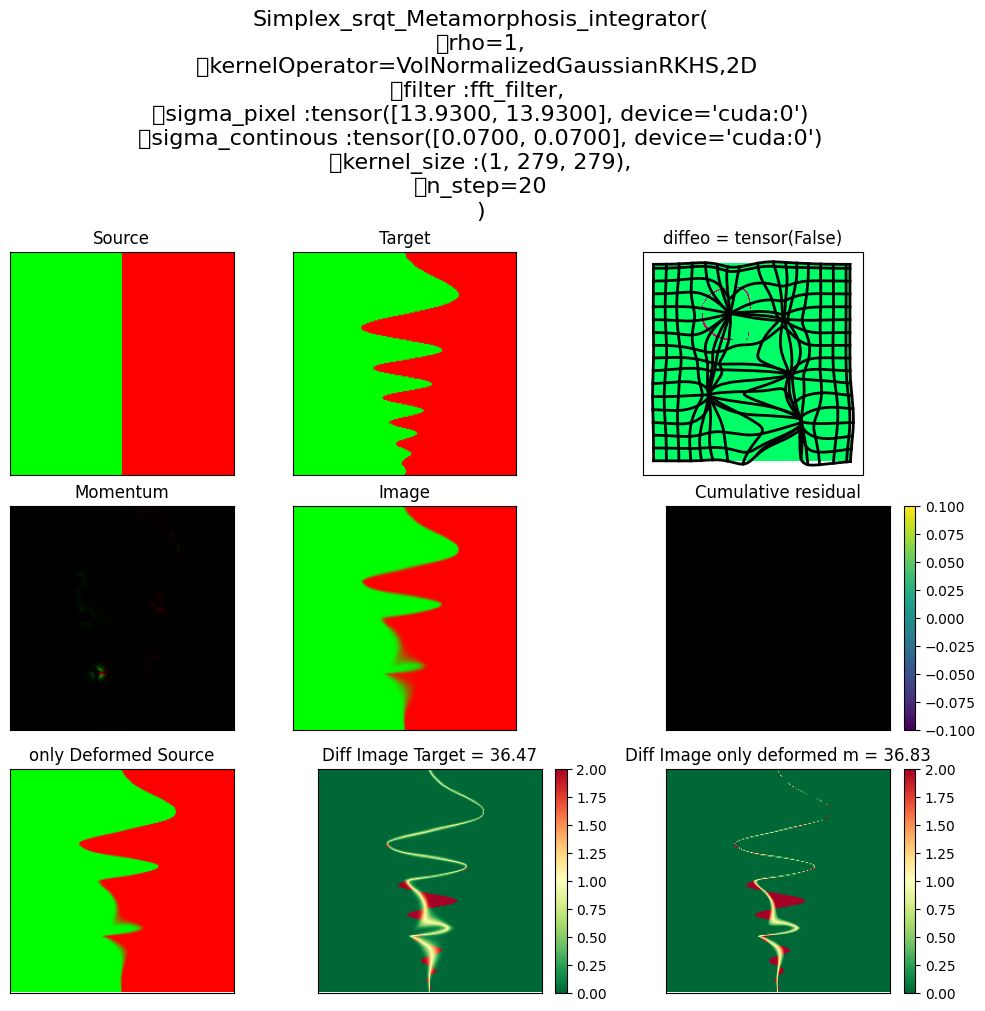

In [10]:
ic.enable()
mr_shooting.to_device('cpu')
end_result = plot_endresult(mr_shooting,save=False, return_all=True,
                                    filename=f"{name}_varySigma_{sigma[0]:.3f}_rho_{rho}_summary.png")

plt.show()

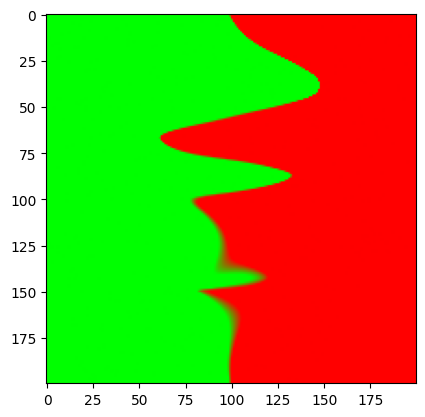

In [13]:
new_img = tb.imgDeform(source.cpu(), mr_shooting.mp.get_deformator(), dx_convention = mr_shooting.dx_convention)
plt.imshow(tp(new_img))

# Path optimizer metamorphosis

Progress: [----------]   2.00%  (Ssd_normalized : ,  0.0612).
Progress: [----------]   3.00%  (Ssd_normalized : ,  0.0397).
Progress: [----------]   4.00%  (Ssd_normalized : ,  0.0298).
Progress: [----------]   5.00%  (Ssd_normalized : ,  0.0274).
Progress: [#---------]   6.00%  (Ssd_normalized : ,  0.0264).
Progress: [#---------]   7.00%  (Ssd_normalized : ,  0.0258).
Progress: [#---------]   8.00%  (Ssd_normalized : ,  0.0243).
Progress: [#---------]   9.00%  (Ssd_normalized : ,  0.0235).
Progress: [#---------]  10.00%  (Ssd_normalized : ,  0.0231).
Progress: [#---------]  11.00%  (Ssd_normalized : ,  0.0228).
Progress: [#---------]  12.00%  (Ssd_normalized : ,  0.0225).
Progress: [#---------]  13.00%  (Ssd_normalized : ,  0.0222).
Progress: [#---------]  14.00%  (Ssd_normalized : ,  0.0221).
Progress: [##--------]  15.00%  (Ssd_normalized : ,  0.0218).
Progress: [##--------]  16.00%  (Ssd_normalized : ,  0.0216).
Progress: [##--------]  17.00%  (Ssd_normalized : ,  0.0212).
Progress

(<Figure size 1000x500 with 2 Axes>,
 array([<Axes: title={'center': 'Lambda = 0.0001 rho = 1'}>, <Axes: >],
       dtype=object))

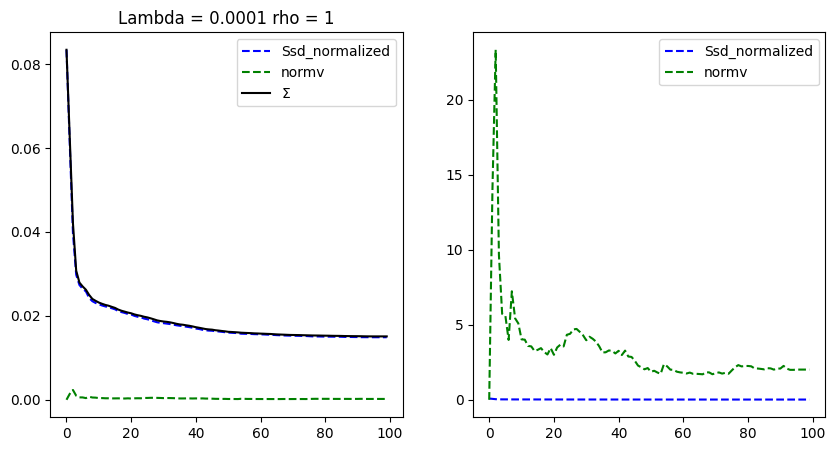

In [11]:
# New metamorphosiis 
# ===========================================================
cost_cst = .0001
n_iter = 100
grad_coef=10

# momentum_ini = mr_op.to_analyse[0].detach().to(device).contiguous()
@monitor_gpu
def pathOptim_meta():
    momentum_ini = torch.zeros((integration_steps,) + source.shape[1:], device = device)
    momentum_ini.requires_grad = True
    
    ic.enable()
    mp = mt.Simplex_sqrt_Metamorphosis_integrator_bis(
        rho=rho,
        kernelOperator=kernelOperator,
        n_step=integration_steps,
        dx_convention=dx_convention,
    )
    mr_op = mt.Simplex_sqrt_Shooting(
        source.clone(),
        target.clone(),
        mp,
        optimizer_method="LBFGS_torch",
        cost_cst=cost_cst,
        data_term=data_cost,
        hamiltonian_integration=True,  # Important pour que le coût d'integration soit calculé sur tout le chemin
        lbfgs_history_size=lbfgs_history,
    )
    mr_op.forward(momentum_ini, n_iter, grad_coef)
    
    return mr_op

mr_op = pathOptim_meta()
print(mr_op)
mr_op.plot_cost()

ic| abstract.py:593 in get_deformation()- 'n_step', 20
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.04547373577952385..0.040009789168834686].


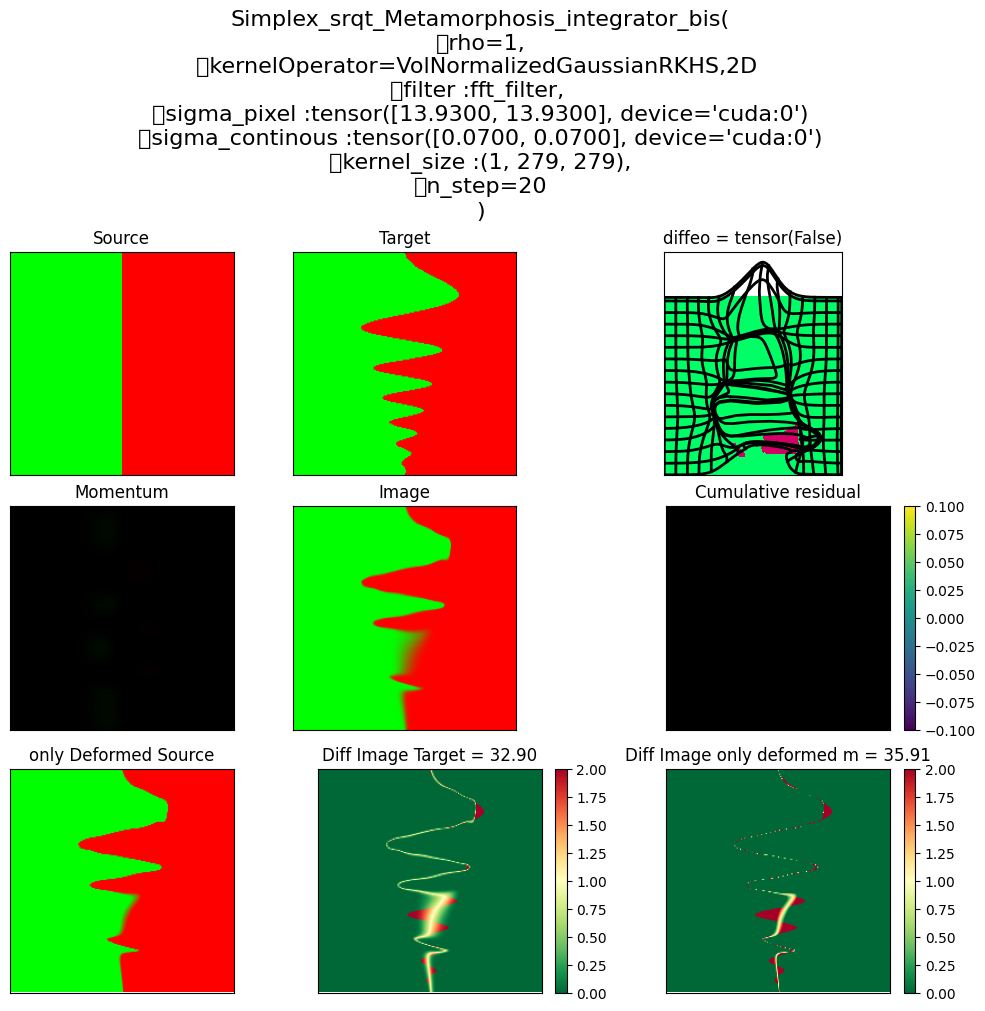

In [12]:
end_result = plot_endresult(mr_op,save=False, return_all=True,
                                    filename=f"{name}_varySigma_{sigma[0]:.3f}_rho_{rho}_summary.png")

plt.show()

## With Pytorch minimize

Josua m'as suggéré que j'essaye de faire des méthodes avec des Méthodes Hessiennes que l'on trouve dans torch-minimize. La Hessienne est calculée par l'autodiff du cout.  Malheuresement ça ne marche pas, à cause de l'interpolation dont le backward n'est pas (ni ne peut être) implémenté. La seule méthode qui fonctione 

In [163]:
from torchmin import minimize

def pathOptim_cost(momentum):
    
    ic.enable()
    mp = mt.Simplex_sqrt_Metamorphosis_integrator_bis(
        rho=rho,
        kernelOperator=kernelOperator,
        n_step=integration_steps,
        dx_convention=dx_convention,
    )
    mr_op = mt.Simplex_sqrt_Shooting(
        source.clone().to(device),
        target.clone().to(device),
        mp,
        optimizer_method="LBFGS_torch",
        cost_cst=cost_cst,
        data_term=data_cost,
        hamiltonian_integration=True,  # Important pour que le coût d'integration soit calculé sur tout le chemin
        lbfgs_history_size=lbfgs_history,
    )
    mr_op.to_device(momentum.device)
    
    return mr_op.cost(momentum)



momentum_ini = torch.zeros((integration_steps,) + source.shape[1:], device = device)
momentum_ini.requires_grad = True

print(momentum_ini.device)

res = minimize(
    pathOptim_cost, 
    momentum_ini, 
    # res.x,                                        # Pour relancer à partir d'une optim précedente même valeur.
    method='l-bfgs', 
    options=dict(line_search='strong-wolfe', lr=10),
    max_iter=500,
    disp=2)
print()
# print('final x: \n{}'.format(res.x))

mp = mt.Simplex_sqrt_Metamorphosis_integrator_bis(
        rho=rho,
        kernelOperator=kernelOperator,
        n_step=integration_steps,
        dx_convention=dx_convention,
)

cuda:0
initial fval: 0.0834
iter   1 - fval: 0.0828
iter   2 - fval: 0.0824
iter   3 - fval: 0.0799
iter   4 - fval: 0.0788
iter   5 - fval: 0.0758
iter   6 - fval: 0.0722
iter   7 - fval: 0.0704
iter   8 - fval: 0.0677
iter   9 - fval: 0.0661
iter  10 - fval: 0.0630
iter  11 - fval: 0.0628
iter  12 - fval: 0.0621
iter  13 - fval: 0.0594
iter  14 - fval: 0.0567
iter  15 - fval: 0.0554
iter  16 - fval: 0.0535
iter  17 - fval: 0.0509
iter  18 - fval: 0.0484
iter  19 - fval: 0.0456
iter  20 - fval: 0.0431
iter  21 - fval: 0.0409
iter  22 - fval: 0.0387
iter  23 - fval: 0.0384
iter  24 - fval: 0.0375
iter  25 - fval: 0.0363
iter  26 - fval: 0.0354
iter  27 - fval: 0.0350
iter  28 - fval: 0.0347
iter  29 - fval: 0.0344
iter  30 - fval: 0.0341
iter  31 - fval: 0.0335
iter  32 - fval: 0.0329
iter  33 - fval: 0.0326
iter  34 - fval: 0.0321
iter  35 - fval: 0.0319
iter  36 - fval: 0.0315
iter  37 - fval: 0.0311
iter  38 - fval: 0.0308
iter  39 - fval: 0.0306
iter  40 - fval: 0.0304
iter  41 - f

/tmp/ipykernel_7198/547649679.py:5: DeprecationWarning: Call to deprecated function gridDef_plot (Please specify the dimension by using gridDef_plot_2d ot gridDef_plot_3d).
  tb.gridDef_plot(mp.get_deformation(), ax[1], check_diffeo=True, color='black', step = 10, )


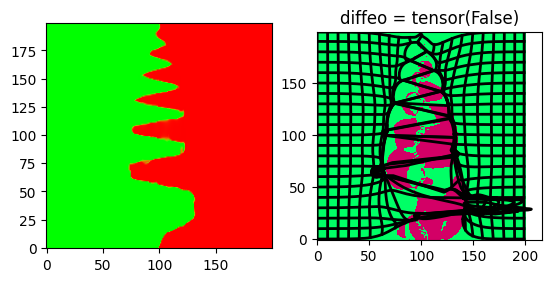

In [167]:
mp.forward(source, res.x, save = True)

fig, ax = plt.subplots(1,2)
ax[0].imshow(tp(mp.image.cpu().detach()), origin='lower')
tb.gridDef_plot(mp.get_deformation(), ax[1], check_diffeo=True, color='black', step = 10, )
plt.show()

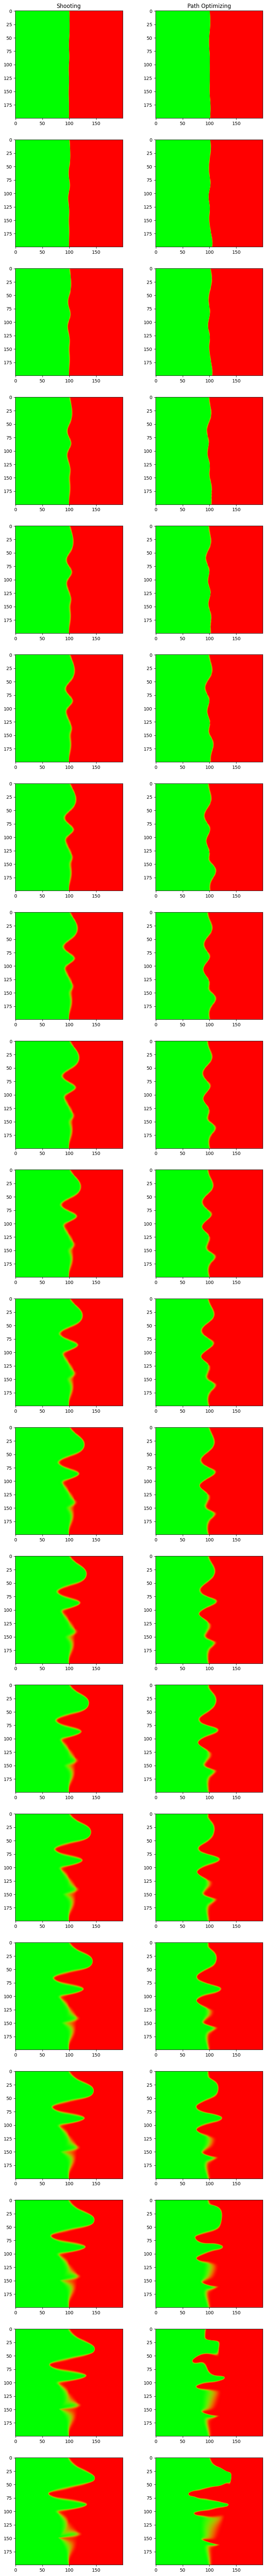

In [14]:
n_step = mr_shooting.mp.n_step
assert mr_shooting.mp.n_step == mr_op.mp.n_step
fig, ax = plt.subplots(n_step,2, figsize=(10,5*n_step))

ax[0,0].set_title("Shooting")
ax[0,1].set_title("Path Optimizing")
for ns in range(n_step):
    ax[ns,0].imshow(tp(mr_shooting.mp.image_stock[ns][None]))
    ax[ns,1].imshow(tp(mr_op.mp.image_stock[ns][None]))

